# Test validity step 1 with JAX : $P(\eta | ...) \propto \eta^t (S_{approx} + E^t (B^t N^{-1} B)^{-1} E) \eta$

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import scipy
import jax
import jax.numpy as jnp
import jax_healpy as jhp
import camb

import micmac as micmac

In [2]:
sys.path.append(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('')))+'/tutorials/')
from func_tools_for_tests import *
from get_freq_maps_SO_64 import *
# freq_maps is defined there

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


(6, 2, 49152)
(6, 2, 49152)


In [3]:
instrument

,frequency,depth_p,depth_i,fwhm,f_sky,status,reference,type,note,experiment
0,27.0,49.5,35.0,91.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
1,39.0,29.7,21.0,63.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
2,93.0,3.7,2.6,30.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
3,145.0,4.7,3.3,17.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
4,225.0,8.9,6.3,11.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
5,280.0,22.6,16.0,9.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT


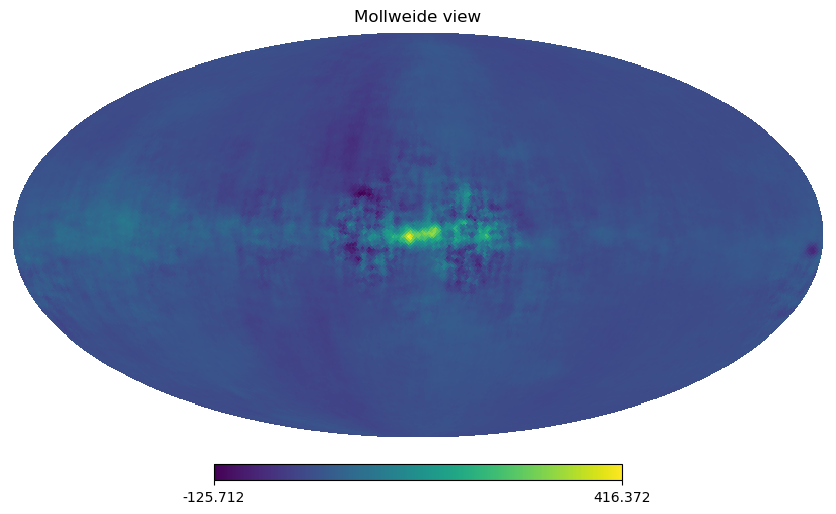

In [4]:
hp.mollview(freq_maps[0,0]) # Freq, nstokes, npix

In [5]:
nstokes = 2
nside = 64
lmax = nside*2
lmin = 2

number_frequencies = freq_maps.shape[0]
number_components = 3

limit_iter_cg=2000
tolerance_CG=10**(-12)

n_iter = 8

number_correlations = int(np.ceil(nstokes**2/2) + np.floor(nstokes/2))

param_dict = {'nside':nside, 'lmax':lmax, 'nstokes':nstokes, 'number_correlations':number_correlations,'number_frequencies':number_frequencies, 'number_components':number_components}
npix = 12*nside**2

In [6]:
all_spectra = generate_power_spectra_CAMB(nside*2, typeless_bool=True)
lensing_spectra = all_spectra['lensed_scalar'][:lmax+1,:]
camb_cls = all_spectra['total'][:lmax+1,:]

c_ell_approx = np.zeros((6,lmax+1))
c_ell_approx[1] = camb_cls.T[1]
c_ell_approx[2] = lensing_spectra.T[2]


Calculating spectra from CAMB !


In [7]:
indices_polar = np.array([1,2,4])

if nstokes == 2:    
    # c_ells_input = c_ells_input[indices_polar,:]
    c_ell_approx = c_ell_approx[indices_polar,:]
    # CMB_map_input = CMB_map_input[1:,:]
    # freq_maps = freq_maps[:,1:,:]

In [8]:
red_cov_approx_matrix = micmac.get_reduced_matrix_from_c_ell(c_ell_approx)[lmin:,...]

In [9]:
depth_p = instrument['depth_p']

freq_inverse_noise = micmac.get_noise_covar(depth_p, nside)

init_mixing_matrix_obj = micmac.InitMixingMatrix(np.array(instrument['frequency']), number_components, pos_special_freqs=[-1,0])
init_params = init_mixing_matrix_obj.init_params()

mixing_matrix_obj = MixingMatrix(instrument['frequency'], number_components, init_params, pos_special_freqs=[-1,0])

mixing_matrix_sampled = mixing_matrix_obj.get_B()

cp_cp_noise = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
cp_freq_inv_noise_sqrt = micmac.get_BtinvN(np.sqrt(freq_inverse_noise), mixing_matrix_sampled)

In [10]:
red_cov_approx_matrix.shape

(127, 2, 2)

In [11]:
input_cmb_maps.shape

(6, 2, 49152)

In [12]:
input_cmb_maps_extended = np.vstack([np.zeros_like(input_cmb_maps[0,0]), input_cmb_maps[0]])

alms_test = hp.map2alm(input_cmb_maps_extended, lmax=lmax)

In [13]:
alms_test.shape

(3, 8385)

In [14]:
8128/127

64.0

In [15]:
red_cov_approx_matrix.shape

(127, 2, 2)

In [28]:
%%time 
# eta_maps = np.zeros((number_frequencies, nstokes, npix))
# eta_maps = jnp.zeros((nstokes, npix))
map_random_x = jnp.empty(0)
map_random_y = jnp.empty(0)
# eta_maps = micmac.get_sampling_eta(param_dict, red_cov_approx_matrix, cp_cp_noise, cp_freq_inv_noise_sqrt, map_random_x=map_random_x, map_random_y=map_random_y, initial_guess=np.copy(eta_maps), lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)
eta_prime_maps_jax = micmac.get_sampling_eta_prime_JAX(param_dict["number_frequencies"],param_dict["nstokes"],param_dict["nside"], red_cov_approx_matrix, cp_cp_noise, cp_freq_inv_noise_sqrt, map_random_x=map_random_x, map_random_y=map_random_y, jax_key_PNRG=jax.random.PRNGKey(1), lmin=lmin, n_iter=n_iter)

Recalculating x !
Recalculating y !
CPU times: user 1.68 s, sys: 328 ms, total: 2 s
Wall time: 526 ms


In [17]:
jitted_get_sampling_eta_prime_JAX = jax.jit(micmac.get_sampling_eta_prime_JAX, static_argnames=['number_frequencies', 'nstokes', 'nside', 'lmin', 'n_iter'])

In [18]:
param_dict

{'nside': 64,
 'lmax': 128,
 'nstokes': 2,
 'number_correlations': 3,
 'number_frequencies': 6,
 'number_components': 3}

In [31]:
%%time 
eta_prime_maps_jax_2 = jitted_get_sampling_eta_prime_JAX(param_dict["number_frequencies"],param_dict["nstokes"],param_dict["nside"], red_cov_approx_matrix, cp_cp_noise, cp_freq_inv_noise_sqrt, map_random_x=map_random_x, map_random_y=map_random_y, jax_key_PNRG=jax.random.PRNGKey(1), lmin=lmin, n_iter=n_iter)

CPU times: user 222 ms, sys: 36.5 ms, total: 259 ms
Wall time: 82.5 ms


In [20]:
eta_prime_maps = jnp.asarray(eta_prime_maps_jax)

In [21]:
eta_maps_extended = np.vstack([np.zeros_like(eta_prime_maps[0]), eta_prime_maps])
c_ells_eta = hp.anafast(eta_maps_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

In [22]:
covariance_noise = np.zeros_like(c_ell_approx)
# covariance_noise[:lmin,...] = scipy.linalg.sqrtm(cp_cp_noise)[0,0]*np.ones_like(c_ell_approx)[:lmin]
covariance_noise[:lmin,...] = cp_cp_noise[0,0]*np.ones_like(c_ell_approx)[:lmin]
analytical_eta_term = (c_ell_approx + covariance_noise)#/np.sqrt(cp_cp_noise[0,0])

ell_arange = np.arange(c_ell_approx.shape[1]) + lmin

In [23]:
number_correl_to_plot = int(np.ceil(nstokes**2/2) + np.floor(nstokes/2))

if nstokes == 3:
    number_subplots_convention = 421
    figsize = (10,10)
    figsize_big = (12,12)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)
elif nstokes == 2:
    number_subplots_convention = 131
    figsize = (14,6)
    figsize_big = figsize
    position_legend = number_correl_to_plot-1
    bbox_to_anchor=(1, 1)
else:
    number_subplots_convention = 111
    figsize = (10,10)
    figsize_big = (10,10)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)

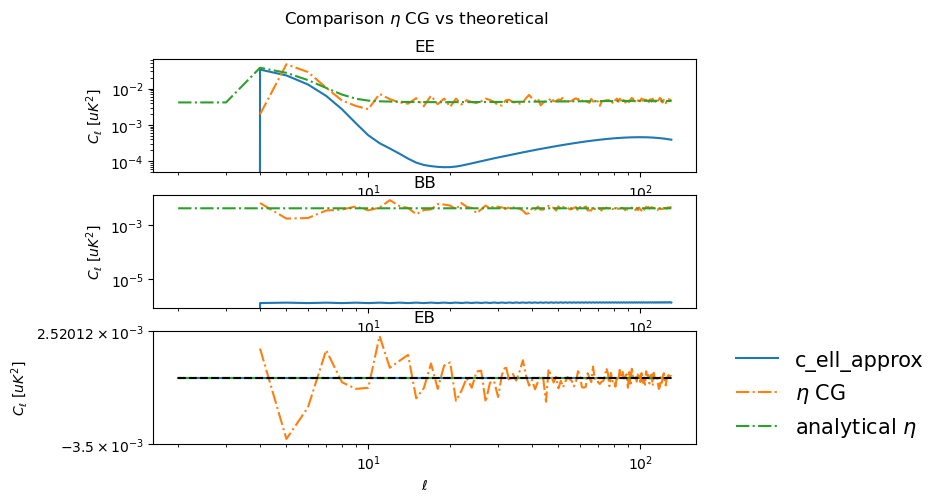

In [24]:
# list_correl = ['TT', 'EE', 'BB', 'TE', 'EB', 'TB']
list_correl = ['EE', 'BB', 'EB']


plt.figure(figsize=(7,5))
plt.suptitle(r"Comparison $\eta$ CG vs theoretical")

for j in range(number_correl_to_plot):
    ax = plt.subplot(311+j)
    plt.title(list_correl[j])

    plt.plot(ell_arange, c_ell_approx.T[:,j], label='c_ell_approx')
    plt.plot(ell_arange[lmin:], c_ells_eta[j,:], '-.', label=r"$\eta$ CG")
    
    plt.plot(ell_arange, analytical_eta_term[j,:], '-.', label=r"analytical $\eta$")
    
    plt.plot([ell_arange[0], ell_arange[-1]], [0,0], '--', color='black')
    if nstokes == 3 and j < number_correl_to_plot-2:
        plt.xticks(color='w')

    if j <= nstokes-1:
        plt.loglog()
        # plt.ylim(ymin=noise_level/10.)
    else:
        plt.xscale('log')
        plt.yscale('symlog')
    # plt.legend()
    if j == position_legend:
        plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
    
    plt.ylabel("$C_\ell$ [$uK^2$]")
    if j == number_correl_to_plot-1:
        plt.xlabel(r"$\ell$")


plt.show()